In [ ]:
train_data_path = "train.csv"
print(train_data_path)
test_data_path = "test.csv"


In [340]:
import pandas as pd
import plotly.express as px

train_data = pd.read_csv(train_data_path, low_memory=False)
test_data = pd.read_csv(test_data_path, low_memory=False)

In [341]:
train_data["D_release_date"] = train_data["D_release_date"].astype(str).map(lambda x : x[-4:]).astype(float)
train_data[['owners_category']] = train_data[['D_owners']].apply(lambda col:pd.Categorical(col).codes)
train_data[['D_reviews']] = train_data[['D_reviews']].apply(lambda col:pd.Categorical(col).codes)
train_data.rename(columns={"D_release_date" : "release_year"}, inplace=True)

In [ ]:
graph_data = train_data[['D_reviews','ccu','VYMAZAT_price']]
graph_data = graph_data.groupby(graph_data['D_reviews'], as_index=False)['ccu'].sum()

fig = px.bar(graph_data, x='D_reviews', y='ccu')
fig.write_image('reviews.png')

In [ ]:
graph_data = train_data[['D_reviews','ccu','VYMAZAT_price']]
graph_data = graph_data.groupby(graph_data['D_reviews'], as_index=False)['VYMAZAT_price'].mean()

fig = px.bar(graph_data, x='D_reviews', y='VYMAZAT_price')
fig.write_image('reviews_price.png')

In [ ]:
both_cost_mean = train_data.loc[(train_data['is_multi_player'] == True) & (train_data['is_single_player'] == True), "VYMAZAT_price"].mean()
single_player_cost_mean = train_data.loc[(train_data['is_multi_player'] == False) & (train_data['is_single_player'] == True), 'VYMAZAT_price'].mean()
multi_player_cost_mean = train_data.loc[(train_data['is_multi_player'] == True) & (train_data['is_single_player'] == False),'VYMAZAT_price'].mean()

import plotly.graph_objects as go
fig = go.Figure(
    data=[go.Bar(y=[both_cost_mean,multi_player_cost_mean, single_player_cost_mean],x=["Single+Multi","MultiPlayer","Single"])],
    layout_title_text="Priemerna cena hier podla poctu hracov"
)
fig.write_image("average_by_sp.png")



In [ ]:
reviews_price = train_data[['positive','negative',"VYMAZAT_price"]]
reviews_price.sort_values(by=['positive'])
#positive = train_data['positive'].values
#negative = train_data['negative'].values
#price = train_data['VYMAZAT_price'].values
#positive



In [ ]:
train_data = train_data.dropna(axis=0, how='any')
train_data.info()

In [ ]:
graph_data = train_data[["VYMAZAT_price", "languages"]]
graph_data = graph_data.groupby(graph_data['languages'], as_index=False).mean()
fig = px.bar(graph_data, x='languages',y='VYMAZAT_price', title="Priemerna cena podla poctu jazykov")
fig.write_image("average_language.png")

In [ ]:
graph_data = train_data[["release_year",'is_single_player','is_multi_player']]
both_data = graph_data.groupby(['release_year','is_multi_player','is_single_player']).size().reset_index(name="Oboje")
single_data = graph_data.groupby(['release_year','is_single_player']).size().reset_index(name="Single")
multi_data = graph_data.groupby(['release_year','is_multi_player']).size().reset_index(name="Multi")

single_data = single_data.loc[single_data['is_single_player'] == True]
multi_data = multi_data.loc[multi_data['is_multi_player'] == True]
both_data = both_data[both_data['is_single_player']==True]
both_data = both_data[both_data['is_multi_player']==True]

together = pd.merge(single_data,multi_data)
together = pd.merge(together,both_data)
together = together.drop(columns=['is_single_player','is_multi_player'])

figure = px.bar(together, x="release_year", y=["Single", "Multi", "Oboje"], title="Roztriedenie hier pocas rokov")
figure.write_html("file.html")

In [ ]:
graph_data = train_data[['D_reviews','ccu']]

In [342]:
test_data["D_release_date"] = test_data["D_release_date"].astype(str).map(lambda x : x[-4:]).astype(float)
test_data[['owners_category']] = test_data[['D_owners']].apply(lambda col:pd.Categorical(col).codes)
test_data[['D_reviews']] = test_data[['D_reviews']].apply(lambda col:pd.Categorical(col).codes)
test_data.rename(columns={"D_release_date" : "release_year"}, inplace=True)

In [343]:
train_data = train_data.drop(['D_appid','D_name','coming_soon',
                            "D_developer","D_publisher","self_published","score","D_owners",
                            "D_genre","VYMAZAT_price",'positive',"publisher_est","negative",
                            "Addictive", "Beautiful", "Classic", "Competitive", "Emotional", "Epic", "Lore-Rich", "Masterpiece", "Well-Written"], axis=1)

In [344]:
test_data = test_data.drop(['D_appid','D_name','coming_soon',
                            "D_developer","D_publisher","self_published","score","D_owners",
                            "D_genre","VYMAZAT_price",'positive',"negative", "publisher_est",
                            "Addictive", "Beautiful", "Classic", "Competitive", "Emotional", "Epic", "Lore-Rich", "Masterpiece", "Well-Written"], axis=1)

In [ ]:
test_data.info()

In [ ]:
train_data.info()

In [345]:
my_tags = ["Action","Adventure","Casual","Experimental","Puzzle","RPG","Simulation","Strategy","FPS",'3D']

In [346]:
def getMyTags(x):
    Dict = eval(str(x))
    #print(Dict)
    if type(Dict) == dict:
      #print(list(Dict.keys()))
      tags = list(Dict.keys())
      return filter_tags(tags,my_tags)
    return Dict

def filter_tags(tags,filter_tags):
    Output = [x for x in tags if x in filter_tags]
    #print(Output)
    return Output

In [347]:
train_data["D_tags"] = train_data['D_tags'].astype(str).map(lambda x: getMyTags(x))
train_data = train_data.dropna(axis=0, how='any')

In [348]:
test_data["D_tags"] = test_data['D_tags'].astype(str).map(lambda x: getMyTags(x))

In [349]:
#OneHotEncodingTags
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
test_data = test_data.join(pd.DataFrame(mlb.fit_transform(test_data.pop('D_tags')),
                          columns=mlb.classes_,
                          index=test_data.index))
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   D_reviews               1000 non-null   int8   
 1   release_year            1000 non-null   float64
 2   is_free                 1000 non-null   bool   
 3   ccu                     1000 non-null   int64  
 4   english                 1000 non-null   bool   
 5   languages               1000 non-null   float64
 6   developer_est           1000 non-null   float64
 7   has_dlc                 1000 non-null   bool   
 8   has_website_linked      1000 non-null   bool   
 9   has_controller_support  1000 non-null   bool   
 10  is_single_player        1000 non-null   bool   
 11  is_multi_player         1000 non-null   bool   
 12  is_early_access         1000 non-null   bool   
 13  mature_content          1000 non-null   bool   
 14  Cult Classic            1000 non-null   b

In [350]:
#OneHotEncodingTags
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
train_data = train_data.join(pd.DataFrame(mlb.fit_transform(train_data.pop('D_tags')),
                          columns=mlb.classes_,
                          index=train_data.index))
train_data = train_data.astype(float)

In [ ]:
train_data

In [ ]:
#Undersampling
train_data = train_data.astype(float)
train_data['is_free'].value_counts()
free = train_data[train_data['is_free'] == float(1)]
not_free = train_data[train_data['is_free']== float(0)]
not_free = not_free.sample(n=len(free), random_state=101)
df = pd.concat([free,not_free],axis=0)
df['is_free'].value_counts()

In [ ]:
import plotly.express as px
#Plot of number of games in each year
values = train_data["release_year"].value_counts().index
names = train_data["release_year"].value_counts().values
fig = px.pie(train_data, values=names, names=values)
fig.update_traces(textinfo='value',hoverinfo='label')
fig.show()

In [ ]:
import plotly.express as px
corr = train_data.corr()
fig = px.imshow(corr, height=800, width=1000)
#fig.show()
fig.write_image("fig1.png")

In [ ]:
train_data.describe()

In [351]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

train_data.describe()
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled = scaler.transform(train_data)
scaled_df = pd.DataFrame(scaled, columns=train_data.columns)

In [ ]:
scaled_df.describe()

In [352]:
X = scaled_df.drop('is_free', axis=1)
y = scaled_df['is_free']

In [ ]:
from sklearn.model_selection import train_test_split
  
# split into 80:20 ration
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)
#print("Number transactions X_train dataset: ", X_train.shape)
#print("Number transactions y_train dataset: ", y_train.shape)
#print("Number transactions X_test dataset: ", X_val.shape)
#print("Number transactions y_test dataset: ", y_val.shape)\

In [353]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X, y.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

#X_train, X_val, y_train, y_val = train_test_split(X_train_res, y_train_res, test_size = 0.2, random_state = 0)

After OverSampling, the shape of train_X: (91668, 29)
After OverSampling, the shape of train_y: (91668,) 

After OverSampling, counts of label '1': 45834
After OverSampling, counts of label '0': 45834


In [354]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_res, y_train_res, test_size = 0.2, random_state = 101)

In [355]:
from keras.models import Sequential
from keras.layers import Dense, Activation
import tensorflow as tf
model = Sequential()
model.add(Dense(92, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [356]:
from keras.callbacks import EarlyStopping
earlyStopFunction = EarlyStopping(monitor='val_loss', 
                           patience=10, restore_best_weights=True)

In [357]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 92)                2760      
                                                                 
 dense_16 (Dense)            (None, 64)                5952      
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,777
Trainable params: 8,777
Non-trainable params: 0
_________________________________________________________________


In [358]:
History = model.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val), callbacks=[earlyStopFunction])

Epoch 1/60
2292/2292 [==============================] - 6s 2ms/step - loss: 0.6246 - accuracy: 0.6464 - val_loss: 0.5892 - val_accuracy: 0.6783
Epoch 2/60
2292/2292 [==============================] - 4s 2ms/step - loss: 0.5735 - accuracy: 0.6933 - val_loss: 0.5693 - val_accuracy: 0.6976
Epoch 3/60
2292/2292 [==============================] - 5s 2ms/step - loss: 0.5563 - accuracy: 0.7085 - val_loss: 0.5562 - val_accuracy: 0.7049
Epoch 4/60
2292/2292 [==============================] - 4s 2ms/step - loss: 0.5449 - accuracy: 0.7170 - val_loss: 0.5479 - val_accuracy: 0.7093
Epoch 5/60
2292/2292 [==============================] - 4s 2ms/step - loss: 0.5360 - accuracy: 0.7226 - val_loss: 0.5412 - val_accuracy: 0.7142
Epoch 6/60
2292/2292 [==============================] - 4s 2ms/step - loss: 0.5285 - accuracy: 0.7283 - val_loss: 0.5344 - val_accuracy: 0.7214
Epoch 7/60
2292/2292 [==============================] - 5s 2ms/step - loss: 0.5215 - accuracy: 0.7338 - val_loss: 0.5279 - val_accuracy:

In [360]:
test_data = test_data.astype(float)
scaled = scaler.transform(test_data)
scaled_df_test = pd.DataFrame(scaled, columns=test_data.columns)
x_test = scaled_df_test.drop('is_free', axis=1)
y_test = scaled_df_test['is_free']
print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)
y_pred = model.predict(x_test).round()

Evaluate on test data
32/32 [==============================] - 0s 2ms/step - loss: 0.6499 - accuracy: 0.6600
test loss, test acc: [0.6499001383781433, 0.6600000262260437]
32/32 [==============================] - 0s 2ms/step


In [362]:
from sklearn.metrics import confusion_matrix
import numpy as np
import plotly.figure_factory as ff
matrix = confusion_matrix(y_test.values, y_pred)
matrix = np.flip(matrix, axis=0)
fig = ff.create_annotated_heatmap(matrix,["Free", "Not Free"], ["Not Free", "Free"])
fig.show()


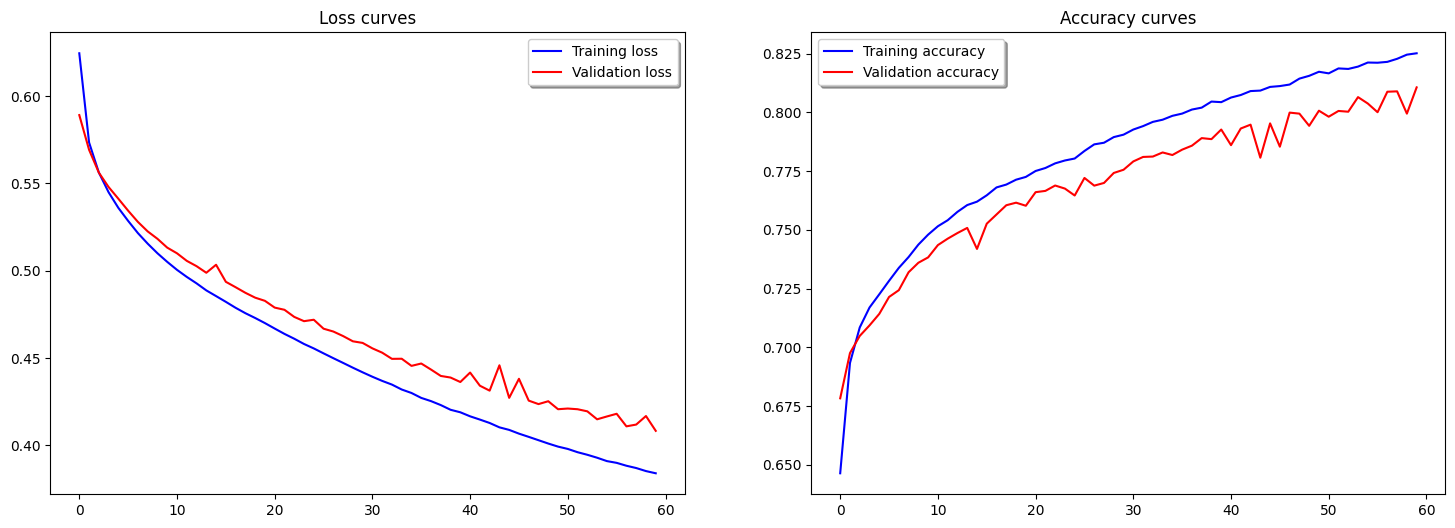

In [361]:
# Plot the loss and accuracy curves over epochs:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()